In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
notes_df = pd.read_csv(DIR + "NOTEEVENTS.csv", low_memory=False)
admissions_df = pd.read_csv(DIR + "ADMISSIONS.csv", low_memory=False)

# Data
## Admissions
Conversion of times to datetime type

In [4]:
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[ns]')
admissions_df['DISCHTIME'] = admissions_df['DISCHTIME'].astype('datetime64[ns]')
admissions_df['DEATHTIME'] = admissions_df['DEATHTIME'].astype('datetime64[ns]')

Sort by subject and admission type and reset the data frame index.

In [5]:
admissions_df = admissions_df.sort_values(['SUBJECT_ID', 'ADMITTIME'])
admissions_df = admissions_df.reset_index(drop = True)

In [6]:
admissions_df['NEXT_ADMITTIME'] = admissions_df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admissions_df['NEXT_ADMISSION_TYPE'] = admissions_df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [7]:
# Update the DataFrame using .loc to avoid SettingWithCopyWarning
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMITTIME'] = pd.NaT
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMISSION_TYPE'] = np.NaN

Fill NA's with the next valid value. Previously sorted.

In [8]:
admissions_df[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions_df.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

Obtain days to readmission: from discharge to next readmission

In [9]:
admissions_df['DAYS_TO_READMISSION'] = (admissions_df['NEXT_ADMITTIME'] - admissions_df['DISCHTIME']).dt.days

## Notes

In [10]:
discharge_notes = notes_df[notes_df['CATEGORY'] == "Discharge summary"]

Take the last row per admission

In [11]:
discharge_notes_ordered = discharge_notes.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1).reset_index()

## Merge Notes and Admissions

In [12]:
admissions_notes = pd.merge(
    admissions_df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_TO_READMISSION','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
    discharge_notes_ordered[['SUBJECT_ID', 'HADM_ID', 'TEXT']], 
    on = ['SUBJECT_ID', 'HADM_ID'], how='left'
)

Remove NEWBORN admissions and create the target variable

In [13]:
# Filter out 'NEWBORN' admission types
adm_notes = admissions_notes[admissions_notes['ADMISSION_TYPE'] != 'NEWBORN'].copy()

# Create the 'READM_WITHIN_30' column using .loc to avoid the warning
adm_notes.loc[:, 'READM_WITHIN_30'] = (adm_notes['DAYS_TO_READMISSION'] < 30).astype('int')


Exlude patients that died during the admission

In [14]:
adm_notes = adm_notes.loc[adm_notes['DEATHTIME'].isnull()]
adm_notes = adm_notes.sample(n = len(adm_notes))
adm_notes = adm_notes.reset_index(drop = True)

In [15]:
adm_notes

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_TO_READMISSION,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT,READM_WITHIN_30
0,78873,168759,2168-07-11 07:15:00,2168-07-15 16:00:00,NaN,NaT,ELECTIVE,NaT,"Name: [**Known lastname 18255**],[**Known fir...",0
1,29967,199462,2138-10-01 13:17:00,2138-10-13 14:31:00,1894.0,2143-12-21 07:20:00,EMERGENCY,NaT,"Name: [**Known lastname 4761**], [**Known fir...",0
2,1761,150904,2148-04-26 01:14:00,2148-05-02 11:29:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2148-4-26**] Dischar...,0
3,88212,159322,2143-09-21 19:31:00,2143-09-24 18:29:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2143-9-21**] ...,0
4,25659,170961,2164-10-17 18:50:00,2164-10-27 12:10:00,NaN,NaT,EMERGENCY,NaT,"Name: [**Known lastname 9245**], [**Known fir...",0
...,...,...,...,...,...,...,...,...,...,...
45316,3660,112598,2138-01-15 08:00:00,2138-01-24 14:30:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2138-1-15**] ...,0
45317,23262,122821,2188-10-21 12:41:00,2188-10-31 14:30:00,250.0,2189-07-09 00:56:00,EMERGENCY,NaT,Admission Date: [**2188-10-21**] ...,0
45318,69176,128091,2183-06-05 13:36:00,2183-06-23 17:06:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2183-6-5**] D...,0
45319,17804,174706,2123-05-14 07:15:00,2123-05-18 13:15:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2123-5-14**] ...,0


In [16]:
adm_notes.to_csv(DIR + 'readmission.csv', index=False)

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [19]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

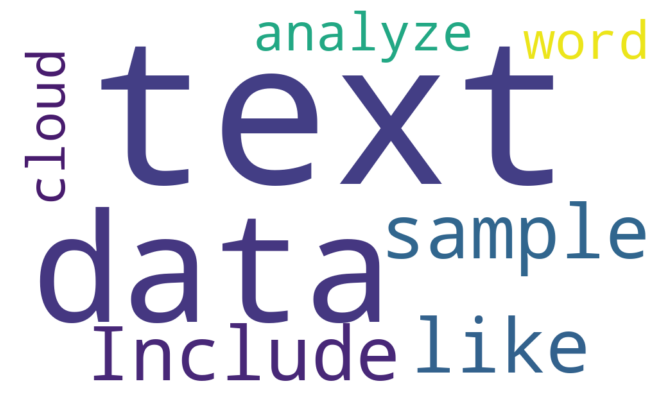

In [20]:
# Define the stop words
stop_words = stopwords.words('english')
custom_stop_words = ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex','do','eat']
stop_words.extend(custom_stop_words)

# Sample text (replace this with your actual text data)
text = "Your text data here. Include any sample text you'd like to analyze for the word cloud."

# Create the word cloud
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=1000, height=600).generate(text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
porter = PorterStemmer()

In [22]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [23]:
print(sum(adm_notes['READM_WITHIN_30'] == 1) )
print(len(adm_notes['READM_WITHIN_30']))

2963
45321
